# Assignment 1: Skip Connections
### CS F425: Deep Learning


In [1]:
# Pytorch for creating, training and testing neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

# Torchvision for image datasets - MNIST and CIFAR-10
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# sklearn for analysis
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold

# for graphs and other uses
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

Section 1: Preparing Data \\
(MNIST, CIFAR-10)

Section 2: MLP and Skip \\
a)MLP \\
b)Resnet : 3 classes \\
c)Densenet : 3 classes

Section 3: Training 2*7 models (18 hl, 100/150) \\
            (loss graph) \\
Testing 4: (all models)

Analysis 5: accuracy (mlp vs skip) \\
            acc (dn vs rn) \\
            continuity (softmax vs tanh)? \\
            n_layers:(3,10?,18) \\
            n_nodes?: (100,200) \\

Appendix 6: Contribution, references

### Data Preprocessing

In [2]:
# Seeded for reproducing results
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

#### Preparing Datasets
We are working with the MNIST and CIFAR-10 datasets.
- MNIST is a collection of *28x28* binary images of hand-written digits from 0 to 9
- CIFAR-10 is a collection of *32x32* colour images of 10 classes of objects and animals

Importing and Normalizing the datasets. Normalizing the data facilitates the training of the network by avoiding local-minima.

In [6]:
ROOT = '.data' # directory to store the data

# Importing the MNIST dataset
train_data_MNIST = datasets.MNIST(root = ROOT, 
                            train = True, 
                            download = True)

# Importing the CIFAR-10 dataset
train_data_CIFAR = datasets.CIFAR10(root = ROOT, 
                            train = True, 
                            download = True)

Files already downloaded and verified


In [7]:
# Normalizing MNIST data
mean_MNIST = train_data_MNIST.data.float().mean() / 255
std_MNIST = train_data_MNIST.data.float().std() / 255

print(f'Calculated mean for MNIST: {mean_MNIST}')
print(f'Calculated standard deviation for MNIST: {std_MNIST}')

# Normalizing CIFAR-10 data
mean_CIFAR = train_data_CIFAR.data.mean() / 255
std_CIFAR = train_data_CIFAR.data.std() / 255

print(f'Calculated mean for CIFAR-10: {mean_CIFAR}')
print(f'Calculated standard deviation for CIFAR-10: {std_CIFAR}')

Calculated mean for MNIST: 0.13066047430038452
Calculated standard deviation for MNIST: 0.30810779333114624
Calculated mean for CIFAR-10: 0.4733630004850899
Calculated standard deviation for CIFAR-10: 0.2515689250632208


#### Transformation of Data
A `transform` states how our data should be augmented and processed. Data augmentation involves manipulating the available training data in a way that artifically creates more training examples. We use `transforms.Compose` to build a list of transformations that will be applied to the image. 

The transforms we use are:
- `RandomRotation` - randomly rotates the image between `(-x, +x)` degrees, where we have set `x = 5`.
- `RandomCrop` - this first adds `padding` around our image, 2 pixels here, to artifically make it bigger, before taking a random `28x28` square crop of the image.
- `ToTensor()` - this converts the image from a PIL image into a PyTorch tensor.
- `Normalize` - this subtracts the mean and divides by the standard deviations given. 

We have two lists of transforms, a train and a test transform. The train transforms are to artificially create more examples for our model to train on. We do not augment our test data in the same way as we want a consistent set of examples to evaluate our final model on. The test data, however, should still be normalized.

In [8]:
# Transformation and Normalization of MNIST training data
train_transforms_MNIST = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding = 2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = [mean_MNIST], std = [std_MNIST])
                                      ])

# Transformation and Normalization of MNIST testing data
test_transforms_MNIST = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = [mean_MNIST], std = [std_MNIST])
                                     ])

In [9]:
# Transformation and Normalization of CIFAR-10 training data
train_transforms_CIFAR = transforms.Compose([
                            transforms.RandomRotation(5),
                            transforms.RandomCrop(32, padding = 2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = [mean_CIFAR], std = [std_CIFAR])
                                      ])

# Transformation and Normalization of CIFAR-10 testing data
test_transforms_CIFAR = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = [mean_CIFAR], std = [std_CIFAR])
                                     ])

Now we have defined our transforms we can then load the train and test data with the relevant transforms defined.

In [10]:
train_data_MNIST = datasets.MNIST(root = ROOT, 
                            train = True, 
                            download = True, 
                            transform = train_transforms_MNIST)

test_data_MNIST = datasets.MNIST(root = ROOT, 
                           train = False, 
                           download = True, 
                           transform = test_transforms_MNIST)

In [11]:
train_data_CIFAR = datasets.CIFAR10(root = ROOT, 
                            train = True, 
                            download = True, 
                            transform = train_transforms_CIFAR)

test_data_CIFAR = datasets.CIFAR10(root = ROOT, 
                           train = False, 
                           download = True, 
                           transform = test_transforms_CIFAR)

Files already downloaded and verified
Files already downloaded and verified


### Looking at the Data


In [12]:
# Train-Test split for MNIST
print('MNIST')
print(f'Number of training examples: {len(train_data_MNIST)}')
print(f'Number of testing examples: {len(test_data_MNIST)}')

# Train-Test split for CIFAR-10
print('CIFAR-10')
print(f'Number of training examples: {len(train_data_CIFAR)}')
print(f'Number of testing examples: {len(test_data_CIFAR)}')

MNIST
Number of training examples: 60000
Number of testing examples: 10000
CIFAR-10
Number of training examples: 50000
Number of testing examples: 10000


Following is an example image from each dataset

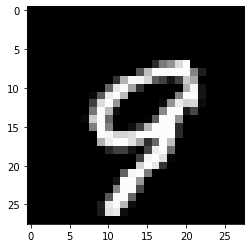

In [13]:
im_mnist = random.choice(train_data_MNIST)

fig_mnist = plt.figure()
plt.imshow(im_mnist[0].view(28, 28).cpu().numpy(), cmap='gray')
plt.show()

#### Validation Set
We create a validation set taking 10% of the training set.

First, we have to define the exact number of examples that we want to be in each split of the training/validation sets.

In [15]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data_MNIST) * VALID_RATIO)
n_valid_examples = len(train_data_MNIST) - n_train_examples

Then, we use the `random_split` function to take a random 10% of the training set to use as a validation set. The remaining 90% will stay as the training set.

In [16]:
train_data_MNIST, valid_data_MNIST = data.random_split(train_data_MNIST, 
                                           [n_train_examples, n_valid_examples])

We can print out the number of examples again to check our splits are correct.

In [17]:
print(f'Number of training examples: {len(train_data_MNIST)}')
print(f'Number of validation examples: {len(valid_data_MNIST)}')
print(f'Number of testing examples: {len(test_data_MNIST)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


In [18]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data_CIFAR) * VALID_RATIO)
n_valid_examples = len(train_data_CIFAR) - n_train_examples

In [19]:
train_data_CIFAR, valid_data_CIFAR = data.random_split(train_data_CIFAR, 
                                           [n_train_examples, n_valid_examples])

In [20]:
print(f'Number of training examples: {len(train_data_CIFAR)}')
print(f'Number of validation examples: {len(valid_data_CIFAR)}')
print(f'Number of testing examples: {len(test_data_CIFAR)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


In [21]:
valid_data_MNIST = copy.deepcopy(valid_data_MNIST)
valid_data_MNIST.dataset.transform = test_transforms_MNIST

In [22]:
valid_data_CIFAR = copy.deepcopy(valid_data_CIFAR)
valid_data_CIFAR.dataset.transform = test_transforms_CIFAR

Next, we'll define a `DataLoader` for each of the training/validation/test sets. We can iterate over these and they will yield batches of images and labels which we can use to train our model.

We only need to shuffle our training set as it will be used for stochastic gradient descent and we want the each batch to be different between epochs. As we aren't using the validation or test sets to update our model parameters they do not need to be shuffled.

Ideally, we want to use the biggest batch size that we can. The 64 here is relatively small and can be increased if our hardware can handle it.

In [23]:
BATCH_SIZE = 64

train_iterator_MNIST = data.DataLoader(train_data_MNIST, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator_MNIST = data.DataLoader(valid_data_MNIST, 
                                 batch_size = BATCH_SIZE)

test_iterator_MNIST = data.DataLoader(test_data_MNIST, 
                                batch_size = BATCH_SIZE)

In [24]:
train_iterator_CIFAR = data.DataLoader(train_data_CIFAR, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator_CIFAR = data.DataLoader(valid_data_CIFAR, 
                                 batch_size = BATCH_SIZE)

test_iterator_CIFAR = data.DataLoader(test_data_CIFAR, 
                                batch_size = BATCH_SIZE)

### Multi-Layer Perceptron
We used a simple fully connected MLP to compare the results of with skip-connected networks. Each network consists of an input layer, an output layer and list of hidden layers. The layers have a uniform number of neurons per layer.

Each different network model has the following common input arguments:
- *in_dim*: Dimensions of input vector (28x28 for MNIST, 32x32 for CIFAR-10)
- *out_dim*: Dimensions of final output vector/number of classes (10 for MNIST, CIFAR-10)
- *n_layers*: Number of hidden layers, default=14. Total layers is 2 more
- *n_nodes*: Number of neurons in each layer, default=100

![](https://miro.medium.com/max/565/1*jfEsZoTqJ6W_6tE1wMCdhQ.jpeg)

In [25]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, n_layers=14, n_nodes=100):
        super().__init__()
        
        # Model Architecture
        self.in_layer = nn.Linear(in_dim, n_nodes) # Input Layer - flattened image data
        self.hidden_layers = nn.ModuleList([nn.Linear(n_nodes, n_nodes) for i in range(n_layers)]) # List of hidden layers
        self.out_layer = nn.Linear(n_nodes, out_dim) # Final layer that gives the classification

    def forward(self, x):
        # Configuring input dimensions
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        
        # Looping over all the layers
        x = F.relu(self.in_layer(x))
        for i,apply_layer in enumerate(self.hidden_layers):
            x = F.relu(apply_layer(x))
        y_pred = self.out_layer(x)
        return y_pred,1

## Skip Connections
Skip connections are extra connections between layers that is used to feed the output of one layer to the input of next layers skipping layers in between. Skip connections were introduced to solve degradation problems and enhance feature reusability. There are three widely-used variants: ResNet, DenseNet and UNet. We have implemented ResNet and DenseNet on an MLP model below.

Further, for each variant, we construct 3 different architectures:
- OneSkip: We skip one intermediate layer for each layer in the network
- SourceSkip: We connect the input layer (or first hidden layer) to each layer in the network
- FullSkip: Each layer is fully connected to every other layer by skips

![](https://github.com/rochishnub/Skip-Connections/blob/main/images/Untitled%20Diagram.jpg?raw=true)

#### DenseNets
In DenseNets, the output of a layer is concatenated with the input to the next layer. Thus the input dimensions increase along the network for DenseNets, whereas for ResNets they remain the same. Due to concatenations the features of previous layers are carried on to the next layers. Our implementation is similar to ResNet.

![](https://pytorch.org/assets/images/densenet1.png)

In [26]:
class OneSkipDN(nn.Module):
    def __init__(self, in_dim, out_dim, n_layers=14, n_nodes=100):
        super().__init__()
        
        self.in_layer = nn.Linear(in_dim, n_nodes)
        self.next_layer = nn.Linear(in_dim+n_nodes, n_nodes)
        self.hidden_layers = nn.ModuleList([nn.Linear(2*n_nodes, n_nodes) for i in range(n_layers-1)])
        self.out_layer = nn.Linear(2*n_nodes, out_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        out_skip = F.relu(self.in_layer(x))
        out_dir = F.relu(self.next_layer(torch.cat((x,out_skip), 1)))

        for _,apply_layer in enumerate(self.hidden_layers):
            out_temp = out_skip
            out_skip = out_dir
            out_dir = F.relu(apply_layer(torch.cat((out_skip, out_temp), 1)))
        
        y_pred = self.out_layer(torch.cat((out_skip, out_dir), 1))
        return y_pred,1

In [27]:
class SourceSkipDN(nn.Module):
    def __init__(self, in_dim, out_dim, n_layers=14, n_nodes=100):
        super().__init__()
        
        self.in_layer = nn.Linear(in_dim, n_nodes)
        self.hidden_layers = nn.ModuleList([nn.Linear(in_dim+n_nodes, n_nodes) for i in range(n_layers)])
        self.out_layer = nn.Linear(in_dim+n_nodes, out_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        out_dir = F.relu(self.in_layer(x))
        for _,apply_layer in enumerate(self.hidden_layers):
            out_dir = F.relu(apply_layer(torch.cat((out_dir, x), 1)))
        y_pred = self.out_layer(torch.cat((out_dir, x), 1))
        return y_pred,1

In [28]:
class FullSkipDN(nn.Module):
    def __init__(self, in_dim, out_dim, n_layers=14, n_nodes=100):
        super().__init__()
        
        self.in_layer = nn.Linear(in_dim, n_nodes)
        self.hidden_layers = nn.ModuleList([nn.Linear(in_dim+(i*n_nodes), n_nodes) for i in range(1,n_layers+1)])
        self.out_layer = nn.Linear(in_dim+((n_layers+1)*n_nodes), out_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        out_skips = [x]
        out_skips.append(F.relu(self.in_layer(x)))

        for _,apply_layer in enumerate(self.hidden_layers):
            nxt_out = F.relu(apply_layer(torch.cat(out_skips, 1)))
            out_skips.append(nxt_out)
        y_pred = self.out_layer(torch.cat(out_skips, 1))
        return y_pred,1

#### ResNets
Residual Nets (ResNet) follow the principle of having residual blocks where the the skipped input is vectorially added to the next layer. In our implementation, each layer depicts a residual block. The number of features in the hidden layers are kept uniform to make addition of vectors easier.

![](https://neurohive.io/wp-content/uploads/2019/01/resnet-e1548261477164.png)

In [29]:
class OneSkipRN(nn.Module):
    def __init__(self, in_dim, out_dim, n_layers=14, n_nodes=100):
        super().__init__()
        
        self.in_layer = nn.Linear(in_dim, n_nodes)
        self.next_layer = nn.Linear(n_nodes, n_nodes)
        self.hidden_layers = nn.ModuleList([nn.Linear(n_nodes, n_nodes) for i in range(n_layers-1)])
        self.out_layer = nn.Linear(n_nodes, out_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        out_skip = F.relu(self.in_layer(x))
        out_dir = F.relu(self.next_layer(out_skip))

        for _,apply_layer in enumerate(self.hidden_layers):
            out_temp = out_skip
            out_skip = out_dir
            out_dir = F.relu(apply_layer(out_temp+out_skip))
        
        y_pred = self.out_layer(out_skip+out_dir)
        return y_pred,1

In [30]:
class SourceSkipRN(nn.Module):
    def __init__(self, in_dim, out_dim, n_layers=14, n_nodes=100):
        super().__init__()
        
        self.in_layer = nn.Linear(in_dim, n_nodes)
        self.next_layer = nn.Linear(n_nodes, n_nodes)
        self.hidden_layers = nn.ModuleList([nn.Linear(n_nodes, n_nodes) for i in range(n_layers-1)])
        self.out_layer = nn.Linear(n_nodes, out_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        out_skip = F.relu(self.in_layer(x))
        out_dir = F.relu(self.next_layer(out_skip))

        for _,apply_layer in enumerate(self.hidden_layers):
            out_dir = F.relu(apply_layer(out_dir+out_skip))
        
        y_pred = self.out_layer(out_skip+out_dir)
        return y_pred,1

In [31]:
class FullSkipRN(nn.Module):
    def __init__(self, in_dim, out_dim, n_layers=14, n_nodes=100):
        super().__init__()
        
        self.in_layer = nn.Linear(in_dim, n_nodes)
        self.next_layer = nn.Linear(n_nodes, n_nodes)
        self.hidden_layers = nn.ModuleList([nn.Linear(n_nodes, n_nodes) for i in range(n_layers-1)])
        self.out_layer = nn.Linear(n_nodes, out_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        x = F.relu(self.in_layer(x))
        out_skips = [x]
        out_skips.append(F.relu(self.next_layer(x)))

        for _,apply_layer in enumerate(self.hidden_layers):
            nxt_out = F.relu(apply_layer(sum(out_skips)))
            out_skips.append(nxt_out)
        
        y_pred = self.out_layer(sum(out_skips))
        return y_pred,1

### Helper Functions

We can create a small function to calculate the number of trainable parameters (weights and biases) in our model - in case all of our parameters are trainable.

In [32]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Next, we'll define a function to calculate the accuracy of our model. This takes the index of the highest value for your prediction and compares it against the actual class label. We then divide how many our model got correct by the amount in the batch to calculate accuracy across the batch.

In [33]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

We finally define our training loop.

This will:
- put our model into `train` mode
- iterate over our dataloader, returning batches of (image, label)
- place the batch on to our GPU, if we have one
- clear the gradients calculated from the last batch
- pass our batch of images, `x`, through to model to get predictions, `y_pred`
- calculate the loss between our predictions and the actual labels
- calculate the accuracy between our predictions and the actual labels
- calculate the gradients of each parameter
- update the parameters by taking an optimizer step
- update our metrics

Some layers act differently when training and evaluating the model that contains them, hence why we must tell our model we are in "training" mode. The model we are using here does not use any of those layers, however it is good practice to get used to putting your model in training mode.

In [34]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

The evaluation loop is similar to the training loop. The differences are:
- we put our model into evaluation mode with `model.eval()`
- we wrap the iterations inside a `with torch.no_grad()`
- we do not zero gradients as we are not calculating any
- we do not calculate gradients as we are not updating parameters
- we do not take an optimizer step as we are not calculating gradients

`torch.no_grad()` ensures that gradients are not calculated for whatever is inside the `with` block. As our model will not have to calculate gradients it will be faster and use less memory. 

In [35]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

The final step before training is to define a small function to tell us how long an epoch took.

In [36]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Training MLP on MNIST

We'll define our model by creating an instance of it and setting the correct input and output dimensions.

In [37]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [38]:
# Not needed
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 220,910 trainable parameters


Next, we'll define our optimizer.
We use the *Adam* algorithm with the default parameters to update our model. 

Then, we define a *criterion*, PyTorch's name for a loss/cost/error function. This function will take in your model's predictions with the actual labels and then compute the loss/cost/error of your model with its current parameters.

`CrossEntropyLoss` both computes the *softmax* activation function on the supplied predictions as well as the actual loss via *negative log likelihood*. 

We then define `device`. This is used to place your model and data on to a GPU, if you have one.

We place our model and criterion on to the device by using the `.to` method.

We're finally ready to train!

During each epoch we calculate the training loss and accuracy, followed by the validation loss and accuracy. We then check if the validation loss achieved is the best validation loss we have seen. If so, we save our model's parameters (called a `state_dict`).

In [39]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

EPOCHS = 10

MLP_MNIST_loss = []
MLP_MNIST_acc = []

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator_MNIST, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator_MNIST, criterion, device)

    MLP_MNIST_loss.append(train_loss)
    MLP_MNIST_acc.append(train_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'MLP_model_MNIST.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 31s
	Train Loss: 1.437 | Train Acc: 41.64%
	 Val. Loss: 0.913 |  Val. Acc: 69.53%
Epoch: 02 | Epoch Time: 0m 30s
	Train Loss: 0.878 | Train Acc: 68.89%
	 Val. Loss: 0.512 |  Val. Acc: 80.05%
Epoch: 03 | Epoch Time: 0m 30s
	Train Loss: 0.490 | Train Acc: 84.24%
	 Val. Loss: 0.276 |  Val. Acc: 92.64%
Epoch: 04 | Epoch Time: 0m 31s
	Train Loss: 0.340 | Train Acc: 90.63%
	 Val. Loss: 0.233 |  Val. Acc: 93.64%
Epoch: 05 | Epoch Time: 0m 32s
	Train Loss: 0.323 | Train Acc: 91.41%
	 Val. Loss: 0.229 |  Val. Acc: 93.98%
Epoch: 06 | Epoch Time: 0m 34s
	Train Loss: 0.256 | Train Acc: 93.17%
	 Val. Loss: 0.175 |  Val. Acc: 95.26%
Epoch: 07 | Epoch Time: 0m 29s
	Train Loss: 0.245 | Train Acc: 93.61%
	 Val. Loss: 0.163 |  Val. Acc: 95.74%
Epoch: 08 | Epoch Time: 0m 29s
	Train Loss: 0.248 | Train Acc: 93.73%
	 Val. Loss: 0.157 |  Val. Acc: 95.96%
Epoch: 09 | Epoch Time: 0m 30s
	Train Loss: 0.221 | Train Acc: 94.33%
	 Val. Loss: 0.147 |  Val. Acc: 96.12%
Epoch: 10 | Epoch T

### Testing MLP on MNIST
Afterwards, we load our the parameters of the model that achieved the best validation loss and then use this to evaluate our model on the test set.

In [40]:
model.load_state_dict(torch.load('MLP_model_MNIST.pt'))
test_loss, test_acc = evaluate(model, test_iterator_MNIST, criterion, device)

MNIST_test_loss = [test_loss]
MNIST_test_acc = [test_acc]

In [41]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.140 | Test Acc: 96.48%


### Training OneSkipDN on MNIST

In [ ]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = OneSkipDN(INPUT_DIM, OUTPUT_DIM)

In [44]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

EPOCHS = 10

OSD_MNIST_loss = []
OSD_MNIST_acc = []

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator_MNIST, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator_MNIST, criterion, device)

    OSD_MNIST_loss.append(train_loss)
    OSD_MNIST_acc.append(train_acc)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'OSD_model_MNIST.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 29s
	Train Loss: 0.214 | Train Acc: 94.63%
	 Val. Loss: 0.185 |  Val. Acc: 95.25%
Epoch: 02 | Epoch Time: 0m 42s
	Train Loss: 0.203 | Train Acc: 94.85%
	 Val. Loss: 0.156 |  Val. Acc: 96.15%
Epoch: 03 | Epoch Time: 0m 32s
	Train Loss: 0.229 | Train Acc: 94.25%
	 Val. Loss: 0.684 |  Val. Acc: 84.78%
Epoch: 04 | Epoch Time: 0m 30s
	Train Loss: 0.242 | Train Acc: 93.78%
	 Val. Loss: 0.133 |  Val. Acc: 96.71%
Epoch: 05 | Epoch Time: 0m 28s
	Train Loss: 0.189 | Train Acc: 95.03%
	 Val. Loss: 0.161 |  Val. Acc: 95.87%
Epoch: 06 | Epoch Time: 0m 28s
	Train Loss: 0.173 | Train Acc: 95.46%
	 Val. Loss: 0.144 |  Val. Acc: 95.96%
Epoch: 07 | Epoch Time: 0m 28s
	Train Loss: 0.207 | Train Acc: 94.71%
	 Val. Loss: 0.155 |  Val. Acc: 96.05%
Epoch: 08 | Epoch Time: 0m 28s
	Train Loss: 0.178 | Train Acc: 95.40%
	 Val. Loss: 0.132 |  Val. Acc: 96.45%
Epoch: 09 | Epoch Time: 0m 29s
	Train Loss: 0.177 | Train Acc: 95.47%
	 Val. Loss: 0.149 |  Val. Acc: 96.02%
Epoch: 10 | Epoch T

### Testing OneSkipDN on MNIST

In [45]:
model.load_state_dict(torch.load('OSD_model_MNIST.pt'))

test_loss, test_acc = evaluate(model, test_iterator_MNIST, criterion, device)
MNIST_test_loss.append(test_loss)
MNIST_test_acc.append(test_acc)

In [46]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.113 | Test Acc: 97.24%


### Training SourceSkipDN on MNIST

In [47]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = SourceSkipDN(INPUT_DIM, OUTPUT_DIM)

In [48]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

EPOCHS = 10

SSD_MNIST_loss = []
SSD_MNIST_acc = []

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator_MNIST, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator_MNIST, criterion, device)
    
    SSD_MNIST_loss.append(train_loss)
    SSD_MNIST_acc.append(train_acc)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'SSD_model_MNIST.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 47s
	Train Loss: 0.432 | Train Acc: 86.48%
	 Val. Loss: 0.152 |  Val. Acc: 95.08%
Epoch: 02 | Epoch Time: 0m 44s
	Train Loss: 0.192 | Train Acc: 94.07%
	 Val. Loss: 0.139 |  Val. Acc: 95.62%
Epoch: 03 | Epoch Time: 0m 45s
	Train Loss: 0.154 | Train Acc: 95.39%
	 Val. Loss: 0.101 |  Val. Acc: 96.89%
Epoch: 04 | Epoch Time: 0m 44s
	Train Loss: 0.134 | Train Acc: 95.88%
	 Val. Loss: 0.113 |  Val. Acc: 96.53%
Epoch: 05 | Epoch Time: 0m 44s
	Train Loss: 0.127 | Train Acc: 96.05%
	 Val. Loss: 0.078 |  Val. Acc: 97.24%
Epoch: 06 | Epoch Time: 0m 42s
	Train Loss: 0.113 | Train Acc: 96.60%
	 Val. Loss: 0.084 |  Val. Acc: 97.40%
Epoch: 07 | Epoch Time: 0m 45s
	Train Loss: 0.114 | Train Acc: 96.56%
	 Val. Loss: 0.084 |  Val. Acc: 97.63%
Epoch: 08 | Epoch Time: 0m 48s
	Train Loss: 0.103 | Train Acc: 96.96%
	 Val. Loss: 0.081 |  Val. Acc: 97.96%
Epoch: 09 | Epoch Time: 0m 46s
	Train Loss: 0.100 | Train Acc: 96.97%
	 Val. Loss: 0.072 |  Val. Acc: 97.86%
Epoch: 10 | Epoch T

### Testing SourceSkipDN on MNIST

In [49]:
model.load_state_dict(torch.load('SSD_model_MNIST.pt'))

test_loss, test_acc = evaluate(model, test_iterator_MNIST, criterion, device)
MNIST_test_loss.append(test_loss)
MNIST_test_acc.append(test_acc)

In [50]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.055 | Test Acc: 98.24%


### Training FullSkipDN on MNIST

In [51]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = FullSkipDN(INPUT_DIM, OUTPUT_DIM)

In [52]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

EPOCHS = 10

FSD_MNIST_loss = []
FSD_MNIST_acc = []

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator_MNIST, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator_MNIST, criterion, device)

    FSD_MNIST_loss.append(train_loss)
    FSD_MNIST_acc.append(train_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'FSD_model_MNIST.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 1m 6s
	Train Loss: 0.324 | Train Acc: 89.76%
	 Val. Loss: 0.142 |  Val. Acc: 96.04%
Epoch: 02 | Epoch Time: 1m 9s
	Train Loss: 0.159 | Train Acc: 95.08%
	 Val. Loss: 0.096 |  Val. Acc: 96.79%
Epoch: 03 | Epoch Time: 1m 2s
	Train Loss: 0.141 | Train Acc: 95.70%
	 Val. Loss: 0.080 |  Val. Acc: 97.72%
Epoch: 04 | Epoch Time: 1m 3s
	Train Loss: 0.123 | Train Acc: 96.30%
	 Val. Loss: 0.074 |  Val. Acc: 97.72%
Epoch: 05 | Epoch Time: 1m 18s
	Train Loss: 0.113 | Train Acc: 96.61%
	 Val. Loss: 0.069 |  Val. Acc: 97.99%
Epoch: 06 | Epoch Time: 1m 29s
	Train Loss: 0.108 | Train Acc: 96.76%
	 Val. Loss: 0.085 |  Val. Acc: 97.47%
Epoch: 07 | Epoch Time: 1m 20s
	Train Loss: 0.102 | Train Acc: 96.96%
	 Val. Loss: 0.072 |  Val. Acc: 97.83%
Epoch: 08 | Epoch Time: 1m 11s
	Train Loss: 0.097 | Train Acc: 97.17%
	 Val. Loss: 0.076 |  Val. Acc: 97.87%
Epoch: 09 | Epoch Time: 1m 12s
	Train Loss: 0.096 | Train Acc: 97.29%
	 Val. Loss: 0.071 |  Val. Acc: 97.76%
Epoch: 10 | Epoch Time:

### Testing FullSkipDN on MNIST

In [53]:
model.load_state_dict(torch.load('FSD_model_MNIST.pt'))

test_loss, test_acc = evaluate(model, test_iterator_MNIST, criterion, device)
MNIST_test_loss.append(test_loss)
MNIST_test_acc.append(test_acc)

In [54]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.057 | Test Acc: 98.27%


### Training OneSkipRN on MNIST

In [55]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = OneSkipRN(INPUT_DIM, OUTPUT_DIM)

In [56]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

EPOCHS = 10

OSR_MNIST_loss = []
OSR_MNIST_acc = []

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator_MNIST, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator_MNIST, criterion, device)

    OSR_MNIST_loss.append(train_loss)
    OSR_MNIST_acc.append(train_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'OSR_model_MNIST.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 29s
	Train Loss: 0.860 | Train Acc: 67.92%
	 Val. Loss: 0.304 |  Val. Acc: 91.27%
Epoch: 02 | Epoch Time: 0m 30s
	Train Loss: 0.305 | Train Acc: 91.45%
	 Val. Loss: 0.224 |  Val. Acc: 93.88%
Epoch: 03 | Epoch Time: 0m 30s
	Train Loss: 0.232 | Train Acc: 93.52%
	 Val. Loss: 0.166 |  Val. Acc: 95.52%
Epoch: 04 | Epoch Time: 0m 30s
	Train Loss: 0.203 | Train Acc: 94.40%
	 Val. Loss: 0.165 |  Val. Acc: 95.37%
Epoch: 05 | Epoch Time: 0m 30s
	Train Loss: 0.179 | Train Acc: 94.98%
	 Val. Loss: 0.150 |  Val. Acc: 95.78%
Epoch: 06 | Epoch Time: 0m 30s
	Train Loss: 0.165 | Train Acc: 95.35%
	 Val. Loss: 0.118 |  Val. Acc: 96.68%
Epoch: 07 | Epoch Time: 0m 29s
	Train Loss: 0.151 | Train Acc: 95.80%
	 Val. Loss: 0.103 |  Val. Acc: 97.06%
Epoch: 08 | Epoch Time: 0m 29s
	Train Loss: 0.141 | Train Acc: 96.13%
	 Val. Loss: 0.087 |  Val. Acc: 97.50%
Epoch: 09 | Epoch Time: 0m 30s
	Train Loss: 0.133 | Train Acc: 96.21%
	 Val. Loss: 0.094 |  Val. Acc: 97.51%
Epoch: 10 | Epoch T

### Testing OneSkipRN on MNIST

In [57]:
model.load_state_dict(torch.load('OSR_model_MNIST.pt'))

test_loss, test_acc = evaluate(model, test_iterator_MNIST, criterion, device)
MNIST_test_loss.append(test_loss)
MNIST_test_acc.append(test_acc)

In [58]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.084 | Test Acc: 97.68%


### Training SourceSkipRN on MNIST

In [59]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = SourceSkipRN(INPUT_DIM, OUTPUT_DIM)

In [60]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

EPOCHS = 10

SSR_MNIST_loss = []
SSR_MNIST_acc = []

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator_MNIST, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator_MNIST, criterion, device)

    SSR_MNIST_loss.append(train_loss)
    SSR_MNIST_acc.append(train_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'SSR_model_MNIST.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 29s
	Train Loss: 0.435 | Train Acc: 86.39%
	 Val. Loss: 0.181 |  Val. Acc: 94.41%
Epoch: 02 | Epoch Time: 0m 29s
	Train Loss: 0.192 | Train Acc: 94.03%
	 Val. Loss: 0.127 |  Val. Acc: 96.18%
Epoch: 03 | Epoch Time: 0m 29s
	Train Loss: 0.155 | Train Acc: 95.30%
	 Val. Loss: 0.107 |  Val. Acc: 96.68%
Epoch: 04 | Epoch Time: 0m 29s
	Train Loss: 0.137 | Train Acc: 95.79%
	 Val. Loss: 0.084 |  Val. Acc: 97.37%
Epoch: 05 | Epoch Time: 0m 31s
	Train Loss: 0.124 | Train Acc: 96.18%
	 Val. Loss: 0.085 |  Val. Acc: 97.27%
Epoch: 06 | Epoch Time: 0m 29s
	Train Loss: 0.116 | Train Acc: 96.47%
	 Val. Loss: 0.091 |  Val. Acc: 97.24%
Epoch: 07 | Epoch Time: 0m 28s
	Train Loss: 0.112 | Train Acc: 96.53%
	 Val. Loss: 0.091 |  Val. Acc: 97.22%
Epoch: 08 | Epoch Time: 0m 28s
	Train Loss: 0.105 | Train Acc: 96.69%
	 Val. Loss: 0.078 |  Val. Acc: 97.61%
Epoch: 09 | Epoch Time: 0m 29s
	Train Loss: 0.101 | Train Acc: 96.91%
	 Val. Loss: 0.077 |  Val. Acc: 97.60%
Epoch: 10 | Epoch T

### Testing SourceSkipRN on MNIST

In [61]:
model.load_state_dict(torch.load('SSR_model_MNIST.pt'))

test_loss, test_acc = evaluate(model, test_iterator_MNIST, criterion, device)
MNIST_test_loss.append(test_loss)
MNIST_test_acc.append(test_acc)

In [62]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.067 | Test Acc: 97.85%


### Training FullSkipRN on MNIST

In [63]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = FullSkipRN(INPUT_DIM, OUTPUT_DIM)

In [64]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

EPOCHS = 10

FSR_MNIST_loss = []
FSR_MNIST_acc = []

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator_MNIST, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator_MNIST, criterion, device)

    FSR_MNIST_loss.append(train_loss)
    FSR_MNIST_acc.append(train_acc)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'FSR_model_MNIST.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 33s
	Train Loss: 0.644 | Train Acc: 79.41%
	 Val. Loss: 0.251 |  Val. Acc: 92.00%
Epoch: 02 | Epoch Time: 0m 40s
	Train Loss: 0.277 | Train Acc: 91.39%
	 Val. Loss: 0.170 |  Val. Acc: 94.63%
Epoch: 03 | Epoch Time: 0m 41s
	Train Loss: 0.221 | Train Acc: 93.13%
	 Val. Loss: 0.164 |  Val. Acc: 94.87%
Epoch: 04 | Epoch Time: 0m 30s
	Train Loss: 0.195 | Train Acc: 93.91%
	 Val. Loss: 0.145 |  Val. Acc: 95.63%
Epoch: 05 | Epoch Time: 0m 30s
	Train Loss: 0.181 | Train Acc: 94.38%
	 Val. Loss: 0.129 |  Val. Acc: 96.02%
Epoch: 06 | Epoch Time: 0m 31s
	Train Loss: 0.163 | Train Acc: 95.00%
	 Val. Loss: 0.122 |  Val. Acc: 96.38%
Epoch: 07 | Epoch Time: 0m 30s
	Train Loss: 0.153 | Train Acc: 95.22%
	 Val. Loss: 0.127 |  Val. Acc: 96.23%
Epoch: 08 | Epoch Time: 0m 31s
	Train Loss: 0.144 | Train Acc: 95.50%
	 Val. Loss: 0.112 |  Val. Acc: 96.79%
Epoch: 09 | Epoch Time: 0m 39s
	Train Loss: 0.137 | Train Acc: 95.73%
	 Val. Loss: 0.107 |  Val. Acc: 96.74%
Epoch: 10 | Epoch T

### Testing FullSkipRN on MNIST

In [65]:
model.load_state_dict(torch.load('FSR_model_MNIST.pt'))

test_loss, test_acc = evaluate(model, test_iterator_MNIST, criterion, device)
MNIST_test_loss.append(test_loss)
MNIST_test_acc.append(test_acc)

In [66]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.093 | Test Acc: 97.09%


### Analysis and Inferences


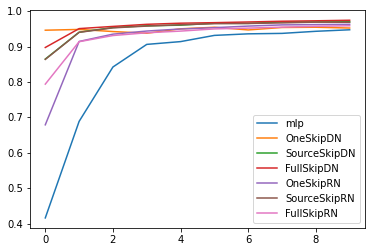

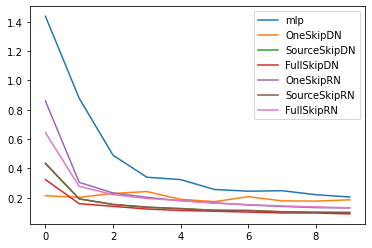

In [74]:
MNIST_train_acc = [MLP_MNIST_acc, OSD_MNIST_acc, SSD_MNIST_acc, FSD_MNIST_acc, OSR_MNIST_acc, SSR_MNIST_acc, FSR_MNIST_acc]
MNIST_train_loss = [MLP_MNIST_loss, OSD_MNIST_loss, SSD_MNIST_loss, FSD_MNIST_loss, OSR_MNIST_loss, SSR_MNIST_loss, FSR_MNIST_loss]

MNIST_legends = ['MLP', 'OneSkipDN', 'SourceSkipDN', 'FullSkipDN', 'OneSkipRN', 'SourceSkipRN', 'FullSkipRN']

for i,acc in enumerate(MNIST_train_acc):
    plt.plot(acc, label=MNIST_legends[i])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

for i,acc in enumerate(MNIST_train_loss):
    plt.plot(acc, label=MNIST_legends[i])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

So we can see that skip connections clearly converges faster than normal MLP. FullSkipDN is the fastest and gives the best accuracy. Interestingly, OneSkipDN does not show monotonous improvement, but fluctuates between very close values.

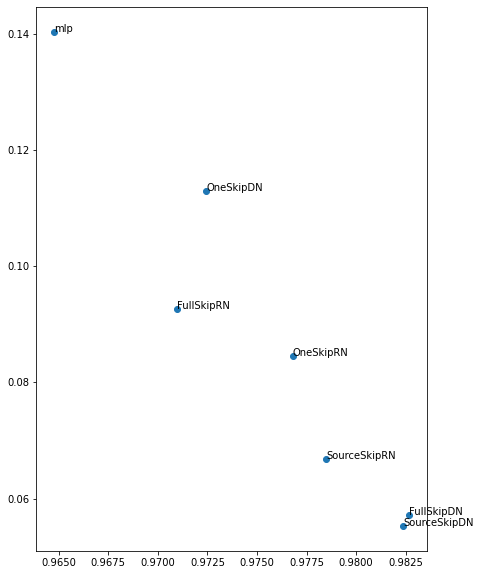

In [84]:

plt.figure(1, figsize=(7,10))
plt.scatter(MNIST_test_acc, MNIST_test_loss)
plt.xlabel('accuracy')
plt.ylabel('loss')
for i,lab in enumerate(MNIST_legends):
    plt.annotate(lab, (MNIST_test_acc[i], MNIST_test_loss[i]))
plt.show()


### Training MLP on CIFAR-10

In [85]:
INPUT_DIM = 32 * 32 * 3
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [86]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

EPOCHS = 10

MLP_CIFAR_loss = []
MLP_CIFAR_acc = []

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator_CIFAR, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator_CIFAR, criterion, device)

    MLP_CIFAR_loss.append(train_loss)
    MLP_CIFAR_acc.append(train_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'MLP_model_CIFAR.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 32s
	Train Loss: 2.048 | Train Acc: 18.37%
	 Val. Loss: 1.988 |  Val. Acc: 20.02%
Epoch: 02 | Epoch Time: 0m 31s
	Train Loss: 1.956 | Train Acc: 21.19%
	 Val. Loss: 1.946 |  Val. Acc: 22.01%
Epoch: 03 | Epoch Time: 0m 32s
	Train Loss: 1.918 | Train Acc: 23.51%
	 Val. Loss: 1.907 |  Val. Acc: 25.47%
Epoch: 04 | Epoch Time: 0m 33s
	Train Loss: 1.889 | Train Acc: 26.58%
	 Val. Loss: 1.858 |  Val. Acc: 28.38%
Epoch: 05 | Epoch Time: 0m 33s
	Train Loss: 1.832 | Train Acc: 30.05%
	 Val. Loss: 1.779 |  Val. Acc: 33.50%
Epoch: 06 | Epoch Time: 0m 29s
	Train Loss: 1.751 | Train Acc: 34.45%
	 Val. Loss: 1.715 |  Val. Acc: 35.88%
Epoch: 07 | Epoch Time: 0m 29s
	Train Loss: 1.693 | Train Acc: 37.03%
	 Val. Loss: 1.685 |  Val. Acc: 37.32%
Epoch: 08 | Epoch Time: 0m 29s
	Train Loss: 1.659 | Train Acc: 38.86%
	 Val. Loss: 1.655 |  Val. Acc: 39.40%
Epoch: 09 | Epoch Time: 0m 29s
	Train Loss: 1.638 | Train Acc: 39.85%
	 Val. Loss: 1.658 |  Val. Acc: 38.98%
Epoch: 10 | Epoch T

### Testing MLP on CIFAR-10

In [87]:
model.load_state_dict(torch.load('MLP_model_CIFAR.pt'))

test_loss, test_acc = evaluate(model, test_iterator_CIFAR, criterion, device)
CIFAR_test_loss = [test_loss]
CIFAR_test_acc = [test_acc]

In [88]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.584 | Test Acc: 42.40%


### Training OneSkipDN on CIFAR-10

In [89]:
INPUT_DIM = 32 * 32 * 3
OUTPUT_DIM = 10

model = OneSkipDN(INPUT_DIM, OUTPUT_DIM)

In [90]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

EPOCHS = 10

OSD_CIFAR_loss = []
OSD_CIFAR_acc = []

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator_CIFAR, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator_CIFAR, criterion, device)

    OSD_CIFAR_loss.append(train_loss)
    OSD_CIFAR_acc.append(train_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'OSD_model_CIFAR.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 38s
	Train Loss: 1.943 | Train Acc: 25.01%
	 Val. Loss: 1.828 |  Val. Acc: 30.44%
Epoch: 02 | Epoch Time: 0m 41s
	Train Loss: 1.771 | Train Acc: 33.69%
	 Val. Loss: 1.733 |  Val. Acc: 36.27%
Epoch: 03 | Epoch Time: 0m 42s
	Train Loss: 1.663 | Train Acc: 38.34%
	 Val. Loss: 1.655 |  Val. Acc: 39.72%
Epoch: 04 | Epoch Time: 0m 42s
	Train Loss: 1.588 | Train Acc: 42.06%
	 Val. Loss: 1.579 |  Val. Acc: 43.57%
Epoch: 05 | Epoch Time: 0m 43s
	Train Loss: 1.531 | Train Acc: 44.95%
	 Val. Loss: 1.587 |  Val. Acc: 43.73%
Epoch: 06 | Epoch Time: 0m 41s
	Train Loss: 1.488 | Train Acc: 46.46%
	 Val. Loss: 1.558 |  Val. Acc: 44.46%
Epoch: 07 | Epoch Time: 0m 44s
	Train Loss: 1.450 | Train Acc: 48.24%
	 Val. Loss: 1.491 |  Val. Acc: 47.09%
Epoch: 08 | Epoch Time: 0m 40s
	Train Loss: 1.422 | Train Acc: 49.42%
	 Val. Loss: 1.473 |  Val. Acc: 47.55%
Epoch: 09 | Epoch Time: 0m 41s
	Train Loss: 1.402 | Train Acc: 49.87%
	 Val. Loss: 1.461 |  Val. Acc: 48.54%
Epoch: 10 | Epoch T

### Testing OneSkipDN on CIFAR-10

In [91]:
model.load_state_dict(torch.load('OSD_model_CIFAR.pt'))

test_loss, test_acc = evaluate(model, test_iterator_CIFAR, criterion, device)
CIFAR_test_loss.append(test_loss)
CIFAR_test_acc.append(test_acc)

In [92]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.413 | Test Acc: 49.23%


### Training SourceSkipDN on CIFAR-10

In [93]:
INPUT_DIM = 32 * 32 * 3
OUTPUT_DIM = 10

model = SourceSkipDN(INPUT_DIM, OUTPUT_DIM)

In [94]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

EPOCHS = 10

SSD_CIFAR_loss = []
SSD_CIFAR_acc = []

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator_CIFAR, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator_CIFAR, criterion, device)

    SSD_CIFAR_loss.append(train_loss)
    SSD_CIFAR_acc.append(train_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'SSD_model_CIFAR.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 1m 29s
	Train Loss: 1.970 | Train Acc: 33.60%
	 Val. Loss: 1.917 |  Val. Acc: 38.69%
Epoch: 02 | Epoch Time: 1m 30s
	Train Loss: 1.825 | Train Acc: 38.84%
	 Val. Loss: 1.956 |  Val. Acc: 39.95%
Epoch: 03 | Epoch Time: 1m 32s
	Train Loss: 1.794 | Train Acc: 40.14%
	 Val. Loss: 1.814 |  Val. Acc: 40.90%
Epoch: 04 | Epoch Time: 1m 37s
	Train Loss: 1.768 | Train Acc: 41.17%
	 Val. Loss: 1.802 |  Val. Acc: 42.78%
Epoch: 05 | Epoch Time: 1m 34s
	Train Loss: 1.736 | Train Acc: 42.42%
	 Val. Loss: 1.854 |  Val. Acc: 39.62%
Epoch: 06 | Epoch Time: 1m 29s
	Train Loss: 1.716 | Train Acc: 42.75%
	 Val. Loss: 1.743 |  Val. Acc: 42.64%
Epoch: 07 | Epoch Time: 1m 34s
	Train Loss: 1.699 | Train Acc: 43.58%
	 Val. Loss: 1.832 |  Val. Acc: 41.53%
Epoch: 08 | Epoch Time: 1m 54s
	Train Loss: 1.691 | Train Acc: 43.87%
	 Val. Loss: 1.827 |  Val. Acc: 41.36%
Epoch: 09 | Epoch Time: 2m 36s
	Train Loss: 1.678 | Train Acc: 44.32%
	 Val. Loss: 1.808 |  Val. Acc: 43.79%
Epoch: 10 | Epoch T

### Testing SourceSkipDN on CIFAR

In [95]:
model.load_state_dict(torch.load('SSD_model_CIFAR.pt'))

test_loss, test_acc = evaluate(model, test_iterator_CIFAR, criterion, device)
CIFAR_test_loss.append(test_loss)
CIFAR_test_acc.append(test_acc)

In [96]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.710 | Test Acc: 43.75%


### Training FullSkipDN on CIFAR-10

In [97]:
INPUT_DIM = 32 * 32 * 3
OUTPUT_DIM = 10

model = FullSkipDN(INPUT_DIM, OUTPUT_DIM)

In [98]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

EPOCHS = 10

FSD_CIFAR_loss = []
FSD_CIFAR_acc = []

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator_CIFAR, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator_CIFAR, criterion, device)

    FSD_CIFAR_loss.append(train_loss)
    FSD_CIFAR_acc.append(train_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'FSD_model_CIFAR.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 1m 45s
	Train Loss: 1.990 | Train Acc: 34.89%
	 Val. Loss: 1.956 |  Val. Acc: 38.13%
Epoch: 02 | Epoch Time: 1m 54s
	Train Loss: 1.863 | Train Acc: 39.49%
	 Val. Loss: 1.900 |  Val. Acc: 39.64%
Epoch: 03 | Epoch Time: 2m 21s
	Train Loss: 1.807 | Train Acc: 41.35%
	 Val. Loss: 2.077 |  Val. Acc: 38.88%
Epoch: 04 | Epoch Time: 2m 53s
	Train Loss: 1.782 | Train Acc: 42.53%
	 Val. Loss: 2.191 |  Val. Acc: 39.77%
Epoch: 05 | Epoch Time: 2m 44s
	Train Loss: 1.748 | Train Acc: 43.38%
	 Val. Loss: 1.932 |  Val. Acc: 41.42%
Epoch: 06 | Epoch Time: 2m 25s
	Train Loss: 1.730 | Train Acc: 43.87%
	 Val. Loss: 1.940 |  Val. Acc: 41.48%
Epoch: 07 | Epoch Time: 2m 36s
	Train Loss: 1.722 | Train Acc: 44.73%
	 Val. Loss: 2.095 |  Val. Acc: 41.67%
Epoch: 08 | Epoch Time: 2m 48s
	Train Loss: 1.699 | Train Acc: 45.70%
	 Val. Loss: 2.138 |  Val. Acc: 41.52%
Epoch: 09 | Epoch Time: 2m 46s
	Train Loss: 1.680 | Train Acc: 45.75%
	 Val. Loss: 2.166 |  Val. Acc: 39.48%
Epoch: 10 | Epoch T

### Testing FullSkipDN on CIFAR-10

In [99]:
model.load_state_dict(torch.load('FSD_model_CIFAR.pt'))

test_loss, test_acc = evaluate(model, test_iterator_CIFAR, criterion, device)
CIFAR_test_loss.append(test_loss)
CIFAR_test_acc.append(test_acc)

In [100]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.879 | Test Acc: 40.22%


### Training OneSkipRN on CIFAR-10

In [101]:
INPUT_DIM = 32 * 32 * 3
OUTPUT_DIM = 10

model = OneSkipRN(INPUT_DIM, OUTPUT_DIM)

In [102]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

EPOCHS = 10

OSR_CIFAR_loss = []
OSR_CIFAR_acc = []

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator_CIFAR, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator_CIFAR, criterion, device)

    OSR_CIFAR_loss.append(train_loss)
    OSR_CIFAR_acc.append(train_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'OSR_model_CIFAR.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 30s
	Train Loss: 1.916 | Train Acc: 26.64%
	 Val. Loss: 1.835 |  Val. Acc: 32.42%
Epoch: 02 | Epoch Time: 0m 31s
	Train Loss: 1.741 | Train Acc: 34.94%
	 Val. Loss: 1.706 |  Val. Acc: 37.46%
Epoch: 03 | Epoch Time: 0m 32s
	Train Loss: 1.647 | Train Acc: 39.90%
	 Val. Loss: 1.635 |  Val. Acc: 40.98%
Epoch: 04 | Epoch Time: 0m 32s
	Train Loss: 1.582 | Train Acc: 43.00%
	 Val. Loss: 1.555 |  Val. Acc: 44.09%
Epoch: 05 | Epoch Time: 0m 32s
	Train Loss: 1.539 | Train Acc: 44.64%
	 Val. Loss: 1.563 |  Val. Acc: 43.95%
Epoch: 06 | Epoch Time: 0m 32s
	Train Loss: 1.499 | Train Acc: 46.12%
	 Val. Loss: 1.532 |  Val. Acc: 44.94%
Epoch: 07 | Epoch Time: 0m 32s
	Train Loss: 1.469 | Train Acc: 47.46%
	 Val. Loss: 1.485 |  Val. Acc: 47.07%
Epoch: 08 | Epoch Time: 0m 32s
	Train Loss: 1.446 | Train Acc: 48.02%
	 Val. Loss: 1.497 |  Val. Acc: 47.01%
Epoch: 09 | Epoch Time: 0m 36s
	Train Loss: 1.421 | Train Acc: 49.07%
	 Val. Loss: 1.450 |  Val. Acc: 48.56%
Epoch: 10 | Epoch T

### Testing OneSkipRN on CIFAR-10

In [103]:
model.load_state_dict(torch.load('OSR_model_CIFAR.pt'))

test_loss, test_acc = evaluate(model, test_iterator_CIFAR, criterion, device)
CIFAR_test_loss.append(test_loss)
CIFAR_test_acc.append(test_acc)

In [104]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.396 | Test Acc: 51.22%


### Training SourceSkipRN on CIFAR-10

In [105]:
INPUT_DIM = 32 * 32 * 3
OUTPUT_DIM = 10

model = SourceSkipRN(INPUT_DIM, OUTPUT_DIM)

In [106]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

EPOCHS = 10

SSR_CIFAR_loss = []
SSR_CIFAR_acc = []

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator_CIFAR, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator_CIFAR, criterion, device)

    SSR_CIFAR_loss.append(train_loss)
    SSR_CIFAR_acc.append(train_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'SSR_model_CIFAR.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 26s
	Train Loss: 1.771 | Train Acc: 37.41%
	 Val. Loss: 1.733 |  Val. Acc: 40.84%
Epoch: 02 | Epoch Time: 0m 30s
	Train Loss: 1.601 | Train Acc: 43.32%
	 Val. Loss: 1.720 |  Val. Acc: 42.86%
Epoch: 03 | Epoch Time: 0m 30s
	Train Loss: 1.538 | Train Acc: 45.43%
	 Val. Loss: 1.709 |  Val. Acc: 41.75%
Epoch: 04 | Epoch Time: 0m 30s
	Train Loss: 1.505 | Train Acc: 46.37%
	 Val. Loss: 1.624 |  Val. Acc: 46.32%
Epoch: 05 | Epoch Time: 0m 30s
	Train Loss: 1.475 | Train Acc: 47.50%
	 Val. Loss: 1.628 |  Val. Acc: 45.79%
Epoch: 06 | Epoch Time: 0m 30s
	Train Loss: 1.450 | Train Acc: 48.48%
	 Val. Loss: 1.631 |  Val. Acc: 45.83%
Epoch: 07 | Epoch Time: 0m 30s
	Train Loss: 1.435 | Train Acc: 48.91%
	 Val. Loss: 1.609 |  Val. Acc: 45.31%
Epoch: 08 | Epoch Time: 0m 28s
	Train Loss: 1.422 | Train Acc: 49.22%
	 Val. Loss: 1.648 |  Val. Acc: 45.75%
Epoch: 09 | Epoch Time: 0m 28s
	Train Loss: 1.403 | Train Acc: 50.11%
	 Val. Loss: 1.606 |  Val. Acc: 47.05%
Epoch: 10 | Epoch T

### Testing SourceSkipRN on CIFAR-10

In [107]:
model.load_state_dict(torch.load('SSR_model_CIFAR.pt'))

test_loss, test_acc = evaluate(model, test_iterator_CIFAR, criterion, device)
CIFAR_test_loss.append(test_loss)
CIFAR_test_acc.append(test_acc)

In [108]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.590 | Test Acc: 47.20%


### Training FullSkipRN on CIFAR-10

In [109]:
INPUT_DIM = 32 * 32 * 3
OUTPUT_DIM = 10

model = FullSkipRN(INPUT_DIM, OUTPUT_DIM)

In [110]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

EPOCHS = 10

FSR_CIFAR_loss = []
FSR_CIFAR_acc = []

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator_CIFAR, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator_CIFAR, criterion, device)

    FSR_CIFAR_loss.append(train_loss)
    FSR_CIFAR_acc.append(train_acc)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'FSR_model_CIFAR.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 28s
	Train Loss: 1.878 | Train Acc: 33.50%
	 Val. Loss: 1.812 |  Val. Acc: 38.96%
Epoch: 02 | Epoch Time: 0m 29s
	Train Loss: 1.641 | Train Acc: 41.33%
	 Val. Loss: 1.715 |  Val. Acc: 41.91%
Epoch: 03 | Epoch Time: 0m 29s
	Train Loss: 1.565 | Train Acc: 44.21%
	 Val. Loss: 1.667 |  Val. Acc: 42.58%
Epoch: 04 | Epoch Time: 0m 29s
	Train Loss: 1.516 | Train Acc: 46.12%
	 Val. Loss: 1.618 |  Val. Acc: 44.52%
Epoch: 05 | Epoch Time: 0m 29s
	Train Loss: 1.483 | Train Acc: 46.96%
	 Val. Loss: 1.624 |  Val. Acc: 44.07%
Epoch: 06 | Epoch Time: 0m 34s
	Train Loss: 1.457 | Train Acc: 47.81%
	 Val. Loss: 1.653 |  Val. Acc: 44.13%
Epoch: 07 | Epoch Time: 0m 32s
	Train Loss: 1.434 | Train Acc: 48.84%
	 Val. Loss: 1.697 |  Val. Acc: 43.79%
Epoch: 08 | Epoch Time: 0m 30s
	Train Loss: 1.418 | Train Acc: 49.35%
	 Val. Loss: 1.648 |  Val. Acc: 43.35%
Epoch: 09 | Epoch Time: 0m 31s
	Train Loss: 1.391 | Train Acc: 50.22%
	 Val. Loss: 1.710 |  Val. Acc: 43.67%
Epoch: 10 | Epoch T

### Testing FullSkipRN on CIFAR-10

In [111]:
model.load_state_dict(torch.load('FSR_model_CIFAR.pt'))

test_loss, test_acc = evaluate(model, test_iterator_CIFAR, criterion, device)
CIFAR_test_loss.append(test_loss)
CIFAR_test_acc.append(test_acc)

In [112]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.577 | Test Acc: 45.09%


### Analysis and Inferences

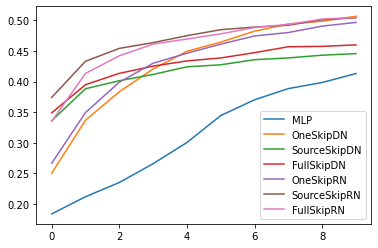

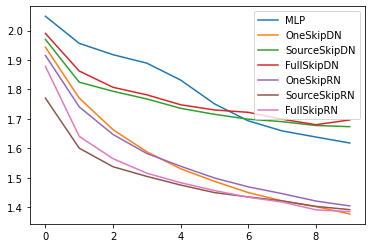

In [113]:
CIFAR_train_acc = [MLP_CIFAR_acc, OSD_CIFAR_acc, SSD_CIFAR_acc, FSD_CIFAR_acc, OSR_CIFAR_acc, SSR_CIFAR_acc, FSR_CIFAR_acc]
CIFAR_train_loss = [MLP_CIFAR_loss, OSD_CIFAR_loss, SSD_CIFAR_loss, FSD_CIFAR_loss, OSR_CIFAR_loss, SSR_CIFAR_loss, FSR_CIFAR_loss]

CIFAR_legends = ['MLP', 'OneSkipDN', 'SourceSkipDN', 'FullSkipDN', 'OneSkipRN', 'SourceSkipRN', 'FullSkipRN']

for i,acc in enumerate(CIFAR_train_acc):
    plt.plot(acc, label=CIFAR_legends[i])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

for i,acc in enumerate(CIFAR_train_loss):
    plt.plot(acc, label=CIFAR_legends[i])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

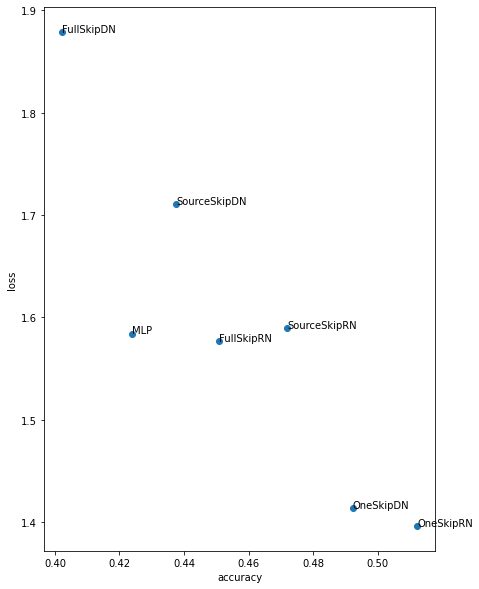

In [124]:
plt.figure(1, figsize=(7,10))
plt.scatter(CIFAR_test_acc, CIFAR_test_loss)
plt.ylabel('loss')
plt.xlabel('accuracy')
for i,lab in enumerate(CIFAR_legends):
    plt.annotate(lab, (CIFAR_test_acc[i], CIFAR_test_loss[i]))
plt.show()

#### Inferences
For the CIFAR-10 dataset, mlp is not the worst network. FullSkipDN has the worst performance. This is because, there overfitting of dataset in 16 layers. Since FullSkipDN has the largest size, it shows the biggest case of overfitting. For the same reason, we see One-Skip networks perform the best because a single skip means it skips intermediate layers that overfit.

The overall performance in poor (<=50% accuracy). The best performance is given when the number of layers are between 7-9.

### Conclusion
From our experiments we can conclude the following:
- For less number of layers (3-5), MLP shows better performance than SkipNets. We believe this is because for less layers there is no effect of vanishing gradient which is solved by ResNets.
- For data with less features, bigger skip networks give better result as shown in MNIST.
- For data with many features, there is a chance for overfitting since unnecessary features are learned by the network. In such cases, skip connections work significantly better because in prominent features learned early are propagated to next layers by skips.

### Appendix

References: 
- [All you need to know about Skip Connections](https://www.analyticsvidhya.com/blog/2021/08/all-you-need-to-know-about-skip-connections/)
- [Skip Connections Intuition](https://theaisummer.com/skip-connections/)

Team:
- Rochishnu Banerjee - 2018A7PS0140G  
Develop the MLP and Skip Connection models.  
Plot the graphs and, inferences and draw conclusions.  
Perform ablation studies with different number of layers, features and loss function
- Saurabh Wadhekar - 2018A7PS0157G  
Prepare the Datasets  
Training and Testing models for both datasets  
- Prashanth Sreenivasan - 2018A7PS0160G  
Preparing the notebook

Github:  
Repository for trained models : [Github](https://github.com/rochishnub/Skip-Connections)